In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 209 kB 19.7 MB/s 


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from PIL import Image 
# un comment if you already download it
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import string
import re
import html


#saving model
import pickle

#inference
import json
import requests
# Model Evaluation
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report

# Modelling 
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D,Bidirectional, Input, LSTM, GRU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
import tensorflow as tf

In [4]:
x_train = pd.read_csv('/content/drive/MyDrive/7015-group-project-main/7015-group-project-main/X_train.csv')
x_valid = pd.read_csv('/content/drive/MyDrive/7015-group-project-main/7015-group-project-main/X_val.csv')
y_train = pd.read_csv('/content/drive/MyDrive/7015-group-project-main/7015-group-project-main/y_train.csv')
y_valid = pd.read_csv('/content/drive/MyDrive/7015-group-project-main/7015-group-project-main/y_val.csv')

In [5]:
x_train

,id,keyword,location,cleaned_text
0,2714,crushed,"Chicago, IL",jimmyfallon crush squirrel bone mortar pestl...
1,7361,obliterate,Cymru araul,mccainenl think spectacular look stonewal rio...
2,1290,bloody,Chicago,can t bloodi wait soni set date stephen king...
3,1932,burning%20buildings,NaN,protest ralli stone mountain atleast they r b...
4,4041,disaster,"Calgary, AB",rbcinsur quot websit disaster tri 3 browse...
...,...,...,...,...
6085,7532,oil%20spill,Street of Dallas,refugio oil spill may costlier bigger project
6086,1821,burned,toronto Û¢ dallas,hate im tri straighten hair brother come swoop...
6087,9504,terrorist,NaN,pull fight hoe call zayn terrorist
6088,2797,curfew,IM LOST,da judg gave di girl 5pm curfew


In [6]:
x_train_final = x_train['cleaned_text'].to_list()
x_valid_final = x_valid['cleaned_text'].to_list()
# x_train_final = np.asarray(x_train).astype('float32')
# x_valid_final = np.asarray(x_valid).astype('float32')
x_train_final[-5:]

['refugio oil spill may costlier bigger project ',
 'hate im tri straighten hair brother come swoop behind scare burn finger',
 'pull fight hoe call zayn terrorist  ',
 'da judg gave di girl 5pm curfew       ',
 'get   150 free bet regist boylesport casino luck destroy  ']

In [7]:
# y_test_final = to_categorical(y_test)
y_train_final = to_categorical(y_train['target'])
y_valid_final = to_categorical(y_valid['target'])
# y_train_final = y_train['target'].to_list()
# y_valid_final = y_valid['target'].to_list()
# y_valid_final[-5:]
y_train_final

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
keras.backend.clear_session()
np.random.seed(12)
tf.random.set_seed(12)

In [9]:
AUTOTUNE = tf.data.AUTOTUNE # auto tune prefetch
batch_size = 128

# data_batches = tf.data.Dataset.from_tensor_slices((x_train_trans, y_train_final)).shuffled_data = preprocessed_data.shuffle(shuffle_buffer_size)


train_final = tf.data.Dataset.from_tensor_slices((x_train_final, y_train_final)).batch(batch_size).shuffle(64).cache().prefetch(AUTOTUNE)
# test_final = tf.data.Dataset.from_tensor_slices((X_test, y_test_final)).batch(batch_size).cache().prefetch(AUTOTUNE)
val_final = tf.data.Dataset.from_tensor_slices((x_valid_final, y_valid_final)).batch(batch_size).shuffle(64).cache().prefetch(AUTOTUNE)

In [10]:
#Define Vectorize 
Vectorize = CountVectorizer()
# Fit only on X_train, and transform X_train
X_train_vec = Vectorize.fit_transform(x_train_final)
# transform data validation
X_train_vec = Vectorize.transform(x_train_final)
X_valid_vec = Vectorize.transform(x_valid_final)

# count Vocab from the vectorizer
count_vocab = len(Vectorize.vocabulary_.keys())
# maximum word count of the documents
max_word_count = max([len(i.split(" ")) for i in x_train_final])

print("Count Vocabs : ",count_vocab)
print("Max Count In a Document :",max_word_count,"word")

vectorize_layer = TextVectorization(
    max_tokens=count_vocab,
    split="whitespace",
    ngrams=None,
    output_mode='int',
    output_sequence_length=max_word_count,
    input_shape=(1,))
    

vectorize_layer.adapt(x_train_final)

Count Vocabs :  13341
Max Count In a Document : 75 word


In [11]:
# Embedding

embedding = Embedding(input_dim=count_vocab,
                      output_dim=128,
                      embeddings_initializer="uniform",
                      input_length=max_word_count)

In [12]:
# callback for stopping early epochs with restore_best_weights
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

In [13]:
from keras import backend as K
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [14]:
model_rnn = Sequential()
model_rnn.add(vectorize_layer)
model_rnn.add(embedding)
model_rnn.add(GlobalAveragePooling1D())
model_rnn.add(Dense(144,activation='relu'))
model_rnn.add(Dense(72,activation='relu'))
model_rnn.add(Dense(27,activation='relu'))
model_rnn.add(Dense(9,activation='relu'))
model_rnn.add(Dense(2,activation='softmax'))

model_rnn.compile(loss='CategoricalCrossentropy',optimizer='adamax',metrics=[f1_m,precision_m, recall_m])

In [15]:
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 75)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 75, 128)           1707648   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 144)               18576     
                                                                 
 dense_1 (Dense)             (None, 72)                10440     
                                                                 
 dense_2 (Dense)             (None, 27)                1

In [16]:
model_rnn_opt = Sequential()
model_rnn_opt.add(vectorize_layer)
model_rnn_opt.add(embedding)
model_rnn_opt.add(GlobalAveragePooling1D())

model_rnn_opt.add(Dense(128,kernel_regularizer=keras.regularizers.l2(),kernel_initializer=keras.initializers.LecunUniform(seed=12)))
model_rnn_opt.add(keras.layers.Dropout(rate=0.52))
model_rnn_opt.add(tf.keras.layers.BatchNormalization())
model_rnn_opt.add(keras.layers.Activation('selu'))

model_rnn_opt.add(Dense(64,kernel_regularizer=keras.regularizers.l2(),kernel_initializer=keras.initializers.LecunUniform(seed=12)))
model_rnn_opt.add(keras.layers.Dropout(rate=.52))
model_rnn_opt.add(tf.keras.layers.BatchNormalization())
model_rnn_opt.add(keras.layers.Activation('selu'))

model_rnn_opt.add(Dense(32,kernel_regularizer=keras.regularizers.l2(),kernel_initializer=keras.initializers.LecunUniform(seed=12)))
model_rnn_opt.add(keras.layers.Dropout(rate=0.52))
model_rnn_opt.add(tf.keras.layers.BatchNormalization())
model_rnn_opt.add(keras.layers.Activation('selu'))

model_rnn_opt.add(Dense(16,kernel_regularizer=keras.regularizers.l2(),kernel_initializer=keras.initializers.LecunUniform(seed=12)))
model_rnn_opt.add(keras.layers.Dropout(rate=0.52))
model_rnn_opt.add(tf.keras.layers.BatchNormalization())
model_rnn_opt.add(keras.layers.Activation('selu'))

model_rnn_opt.add(Dense(2,activation='softmax'))


model_rnn_opt.compile(loss='CategoricalCrossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.0022),metrics=[f1_m,precision_m,recall_m])

In [17]:
model_rnn_opt.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 75)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 75, 128)           1707648   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_5 (Dense)             (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization (BatchN  (None, 128)             

In [22]:
model_rnn_hist = model_rnn.fit(train_final,
                         epochs=100,
                         validation_data=(val_final),
                         callbacks=[early_stopping_cb],class_weight = { 0 : 10 , 1 : 150  ,2 : 25})


Epoch 1/100
48/48 [==============================] - 1s 13ms/step - loss: 8.6394 - f1_m: 0.4329 - precision_m: 0.4329 - recall_m: 0.4329 - val_loss: 0.7643 - val_f1_m: 0.4201 - val_precision_m: 0.4201 - val_recall_m: 0.4201
Epoch 2/100
48/48 [==============================] - 0s 9ms/step - loss: 7.2562 - f1_m: 0.4329 - precision_m: 0.4329 - recall_m: 0.4329 - val_loss: 0.7050 - val_f1_m: 0.4201 - val_precision_m: 0.4201 - val_recall_m: 0.4201
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 6.9800 - f1_m: 0.4329 - precision_m: 0.4329 - recall_m: 0.4329 - val_loss: 0.6945 - val_f1_m: 0.4201 - val_precision_m: 0.4201 - val_recall_m: 0.4201
Epoch 4/100
48/48 [==============================] - 0s 7ms/step - loss: 6.9016 - f1_m: 0.5430 - precision_m: 0.5430 - recall_m: 0.5430 - val_loss: 0.6846 - val_f1_m: 0.5799 - val_precision_m: 0.5799 - val_recall_m: 0.5799
Epoch 5/100
48/48 [==============================] - 0s 7ms/step - loss: 6.8438 - f1_m: 0.5671 - precision_

In [32]:
model_opt_hist = model_rnn_opt.fit(train_final,
                         epochs=10,
                         validation_data=(val_final), 
                         callbacks=[early_stopping_cb],class_weight = { 0:1.5, 1:0.4 ,2:0.5 },verbose=1)

Epoch 1/10
48/48 [==============================] - 0s 10ms/step - loss: 0.0639 - f1_m: 0.9862 - precision_m: 0.9862 - recall_m: 0.9862 - val_loss: 2.1899 - val_f1_m: 0.6923 - val_precision_m: 0.6923 - val_recall_m: 0.6923
Epoch 2/10
48/48 [==============================] - 0s 10ms/step - loss: 0.0636 - f1_m: 0.9855 - precision_m: 0.9855 - recall_m: 0.9855 - val_loss: 2.0881 - val_f1_m: 0.7176 - val_precision_m: 0.7176 - val_recall_m: 0.7176
Epoch 3/10
48/48 [==============================] - 0s 9ms/step - loss: 0.0667 - f1_m: 0.9840 - precision_m: 0.9840 - recall_m: 0.9840 - val_loss: 1.6820 - val_f1_m: 0.7484 - val_precision_m: 0.7484 - val_recall_m: 0.7484
Epoch 4/10
48/48 [==============================] - 0s 9ms/step - loss: 0.0576 - f1_m: 0.9869 - precision_m: 0.9869 - recall_m: 0.9869 - val_loss: 1.7920 - val_f1_m: 0.6830 - val_precision_m: 0.6830 - val_recall_m: 0.6830
Epoch 5/10
48/48 [==============================] - 0s 9ms/step - loss: 0.0653 - f1_m: 0.9851 - precision_m: 0

In [20]:
# model_rnn.evaluate(x_valid_final,y_valid_final)

Text(0.5, 1.0, 'RNN Opptimize')

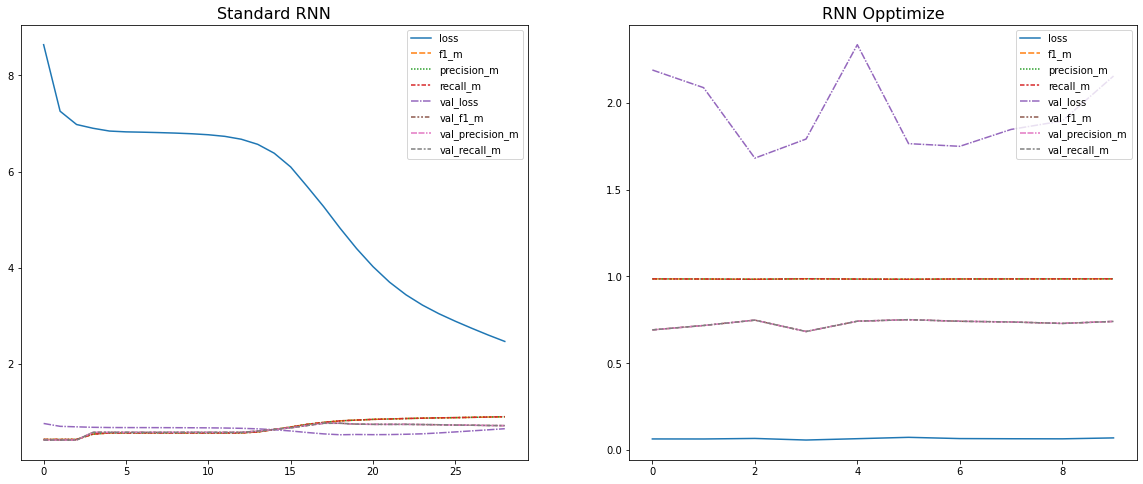

In [33]:
fig,ax = plt.subplots(ncols= 2,figsize=(20,8))

sns.lineplot(data=pd.DataFrame(model_rnn_hist.history),ax=ax[0])
ax[0].set_title("Standard RNN",fontsize= 16)

sns.lineplot(data=pd.DataFrame(model_opt_hist.history),ax=ax[1])
ax[1].set_title("RNN Opptimize",fontsize= 16)